# Predictive Models for Acute Oral Systemic Toxicity

The objective of this project is to leverage the combined expertise of the international modeling community to develop predictive models for acute oral toxicity based on regulatory needs submitted by ICCVAM agencies. Models developed for the project will be evaluated, and those meeting defined criteria will be used to generate consensus toxicity predictions of acute oral toxicity endpoints of interest to regulatory agencies. 

Based on the range of regulatory criteria and decision contexts used by ICCVAM agencies, a total of five different modeling endpoints have been identified. Participants can build models to predict one or more of the following endpoints:

+ Very toxic (<50\ mg/kg vs. all others)
+ Nontoxic (>2000\ mg/kg vs. all others)
+ LD50 point estimates
+ Hazard categories under the EPA classification system (n=4) 
+ Hazard categories under the GHS classification system (n=5; Category 5 and Not Classified combined into a single category)

## Data Exploration of .csv

In [43]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from rdkit.Chem import PandasTools

In [2]:
df = pd.read_csv('data/training_set.csv', sep='\t')

In [3]:
df.head()

,CASRN,DTXSID,Chemical_Name,Structure_Source,Canonical_QSARr,Salt_Solvent,InChI_Code_QSARr,InChI_Key_QSARr,LD50_mgkg,EPA_category,GHS_category,very_toxic,nontoxic
0,100-00-5,DTXSID5020281,1-Chloro-4-nitrobenzene,EPA_DSSTox,[O-][N+](=O)C1C=CC(Cl)=CC=1,?,InChI=1S/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,CZGCEKJOLUNIFY-UHFFFAOYSA-N,460.0,False,False,2.0,4.0
1,100-01-6,DTXSID8020961,4-Nitroaniline,EPA_DSSTox,NC1=CC=C(C=C1)[N+]([O-])=O,?,"InChI=1S/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,7H2",TYMLOMAKGOJONV-UHFFFAOYSA-N,750.0,False,False,3.0,4.0
2,100-02-7,DTXSID0021834,4-Nitrophenol,EPA_DSSTox,[O-][N+](=O)C1C=CC(O)=CC=1,?,"InChI=1S/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",BTJIUGUIPKRLHP-UHFFFAOYSA-N,170.0,False,False,2.0,3.0
3,100-14-1,DTXSID4025745,4-Nitrobenzyl chloride,EPA_DSSTox,[O-][N+](=O)C1C=CC(CCl)=CC=1,?,"InChI=1S/C7H6ClNO2/c8-5-6-1-3-7(4-2-6)9(10)11/h1-4H,5H2",KGCNHWXDPDPSBV-UHFFFAOYSA-N,1809.0,False,False,3.0,4.0
4,100-15-2,DTXSID7025635,N-Methyl-4-nitroaniline,EPA_DSSTox,CNC1C=CC(=CC=1)[N+]([O-])=O,?,"InChI=1S/C7H8N2O2/c1-8-6-2-4-7(5-3-6)9(10)11/h2-5,8H,1H3",XIFJZJPMHNUGRA-UHFFFAOYSA-N,NaN,True,False,3.0,5.0


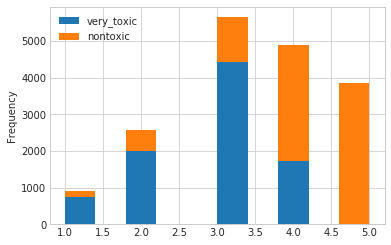

In [44]:
df[['very_toxic', 'nontoxic']].plot.hist(stacked=True)

## Data exploration of .sdf

In [60]:
sdf_df = PandasTools.LoadSDF('data/trainingset_171127.sdf', molColName=None)

In [61]:
sdf_df.head(1)

,CASRN,Canonical_QSARr,DTXSID,EPA_category,GHS_category,ID,InChI Key_QSARr,InChI_Code_QSARr,LD50_mgkg,Name,Salt_Solvent,Structure_Source,nontoxic,very_toxic
0,5894-60-0,CCCCCCCCCCCCCCCC[Si](Cl)(Cl)Cl,DTXSID10884196,,,5894-60-0,RYPYGDUZKOPBEL-UHFFFAOYSA-N,"InChI=1S/C16H33Cl3Si/c1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-20(17,18)19/h2-16H2,1H3",,"Silane, trichlorohexadecyl-",?,EPA_DSSTox,FALSE,FALSE


In [62]:
sdf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8994 entries, 0 to 8993
Data columns (total 14 columns):
CASRN               8994 non-null object
Canonical_QSARr     8994 non-null object
DTXSID              8994 non-null object
EPA_category        8994 non-null object
GHS_category        8994 non-null object
ID                  8994 non-null object
InChI Key_QSARr     8994 non-null object
InChI_Code_QSARr    8994 non-null object
LD50_mgkg           8994 non-null object
Name                8994 non-null object
Salt_Solvent        8994 non-null object
Structure_Source    8994 non-null object
nontoxic            8994 non-null object
very_toxic          8994 non-null object
dtypes: object(14)
memory usage: 1.0+ MB


### Data cleaning

In [63]:
# objects to numeric
sdf_df.LD50_mgkg = pd.to_numeric(sdf_df.LD50_mgkg)
sdf_df.GHS_category = pd.to_numeric(sdf_df.GHS_category)
sdf_df.EPA_category = pd.to_numeric(sdf_df.EPA_category)

# TRUE/FALSE to bolean
bool_dict = {'FALSE':True, 'TRUE':False}
sdf_df.nontoxic = sdf_df.nontoxic.map(bool_dict)
sdf_df.very_toxic = sdf_df.very_toxic.map(bool_dict)

In [64]:
sdf_df.head(2)

,CASRN,Canonical_QSARr,DTXSID,EPA_category,GHS_category,ID,InChI Key_QSARr,InChI_Code_QSARr,LD50_mgkg,Name,Salt_Solvent,Structure_Source,nontoxic,very_toxic
0,5894-60-0,CCCCCCCCCCCCCCCC[Si](Cl)(Cl)Cl,DTXSID10884196,NaN,NaN,5894-60-0,RYPYGDUZKOPBEL-UHFFFAOYSA-N,"InChI=1S/C16H33Cl3Si/c1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-20(17,18)19/h2-16H2,1H3",NaN,"Silane, trichlorohexadecyl-",?,EPA_DSSTox,True,True
1,101-20-2,O=C(NC1C=C(Cl)C(Cl)=CC=1)NC1C=CC(Cl)=CC=1,DTXSID4026214,NaN,5.0,101-20-2,ICUTUKXCWQYESQ-UHFFFAOYSA-N,"InChI=1S/C13H9Cl3N2O/c14-8-1-3-9(4-2-8)17-13(19)18-10-5-6-11(15)12(16)7-10/h1-7H,(H2,17,18,19)",NaN,Triclocarban,?,EPA_DSSTox,False,True


Text(0.5,1,'very toxic')

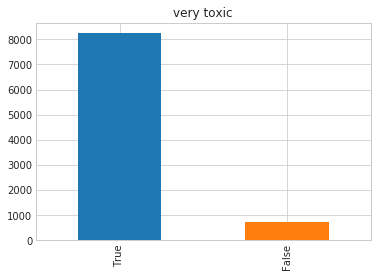

In [65]:
sdf_df.very_toxic.value_counts().plot.bar()
plt.title('very toxic')

Text(0.5,1,'nontoxic')

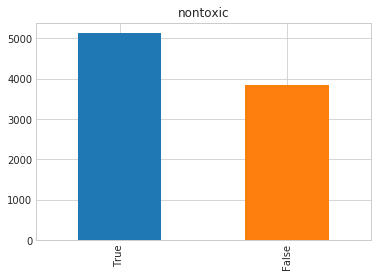

In [66]:
sdf_df.nontoxic.value_counts().plot.bar()
plt.title('nontoxic')

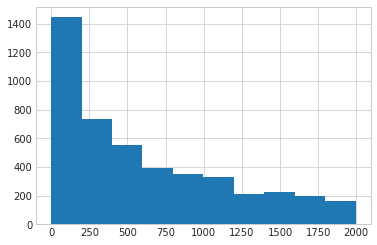

In [67]:
sdf_df.LD50_mgkg[sdf_df.LD50_mgkg < 2000].hist()

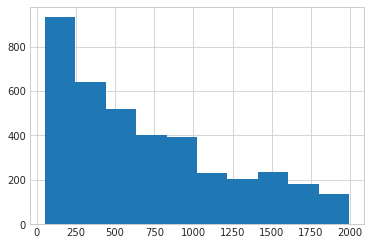

In [68]:
sdf_df[sdf_df.nontoxic & sdf_df.very_toxic].LD50_mgkg.hist()

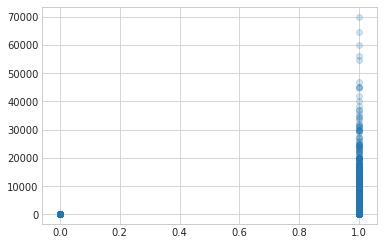

In [81]:
plt.scatter(sdf_df.very_toxic, sdf_df.LD50_mgkg, alpha = 0.2)
# plt.xticks([1,0])
plt.show()

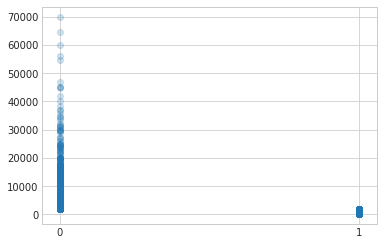

In [80]:
plt.scatter(sdf_df.nontoxic, sdf_df.LD50_mgkg, alpha = 0.2)
plt.xticks([1,0])
plt.show()